In [5]:
import pandas as pd

# ------------------------------------------------------------------
# Charger les métriques Wi-Fi et iPerf client
df_wifi = pd.read_json("wifi_log2.jsonl", lines=True)
df_wifi = df_wifi[df_wifi["throughput_bps"].notnull()].copy()

# Aplatir la liste des clients
df_clients = df_wifi.explode("clients")
clients_data = pd.json_normalize(df_clients["clients"])

# Colonnes globales à conserver
global_cols = [c for c in df_clients.columns if c != "clients"]
for col in ["nss", "rts_cts"]:
    if col not in global_cols:
        df_clients[col] = pd.NA
        global_cols.append(col)

global_data = df_clients[global_cols].reset_index(drop=True)
final_df = pd.concat([global_data, clients_data.reset_index(drop=True)], axis=1)

# ------------------------------------------------------------------
# Charger les métriques iPerf serveur
df_server = pd.read_json("trafic_metrics_server.jsonl", lines=True)

# ------------------------------------------------------------------
# Fusionner sur la colonne traffic_label
df_merged = pd.merge(
    final_df,
    df_server,
    on="traffic_label",
    suffixes=('', '_server'),
    how="left"  # on conserve toutes les lignes du client même si pas de match côté serveur
)

# ------------------------------------------------------------------
# Export CSV
df_merged.to_csv("wifi_dataset_with_server.csv", index=False, encoding="utf-8")
print(f" Fichier final fusionné enregistré avec {len(df_merged)} lignes")
print(df.columns.tolist())



✅ Fichier final fusionné enregistré avec 3607 lignes
['timestamp', 'traffic_label', 'channel', 'frequency_mhz', 'bandwidth_mhz', 'tx_power_dbm', 'cwmin', 'cwmax', 'noise_floor_dbm', 'channel_busy_percent', 'nss', 'rts_cts', 'latency_min_ms', 'latency_avg_ms', 'latency_max_ms', 'client_mac', 'tx_delta_bytes', 'estimated_throughput_bps', 'proto', 'streams', 'udp_rate', 'tcp_window', 'throughput_bps', 'loss_pct', 'jitter_ms', 'client_mac.1', 'signal_rssi_dbm', 'tx_retries', 'tx_failed', 'tx_bitrate_mbps', 'rx_bitrate_mbps', 'tx_bytes', 'rx_bytes', 'mcs_index', 'timestamp_server', 'proto_server', 'streams_server', 'throughput_received_bps', 'loss_pct_server', 'jitter_ms_server']


In [9]:
import os, pandas as pd, json, sys

print("Current working dir:", os.getcwd())
print("Files here:", os.listdir('.'))


Current working dir: /home/chaabenm
Files here: ['Downloads', 'Untitled2.ipynb', '.ssh', 'survey_log.csv', 'Templates', 'wifi_log.jsonl', '.gnupg', '.npm', 'Scripts', 'Desktop', '.bash_history', '.pki', '.local', '.jupyter', 'Documents', '.cache', '.bash_logout', 'Pictures', 'retry_log.csv', 'Untitled1.ipynb', 'set_wifi_config.sh', 'collect_survey_retry.sh', '.bashrc', 'WifiAnalyser.ipynb', '.profile', 'wifi_dataset_filtered.csv', '.config', 'wifi_dataset.csv', 'Music', '.ipynb_checkpoints', 'Public', 'Videos', '.sudo_as_admin_successful', 'snap', '.ipython', 'wifi_log2.jsonl', 'Untitled.ipynb']


/tmp/ipykernel_4526/2963473564.py:23: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/chaabenm/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


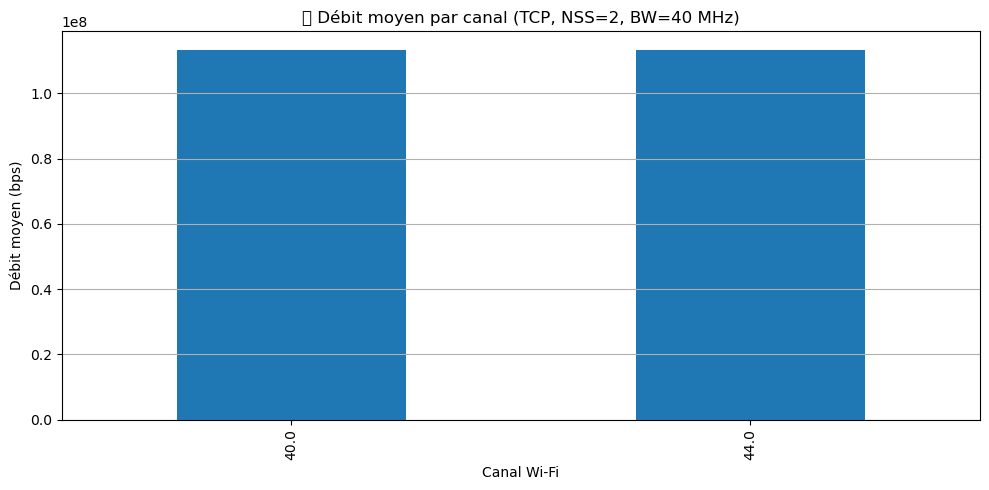

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Nettoyer les colonnes
df.columns = df.columns.str.strip().str.lower()

# Filtrage : TCP uniquement, NSS = 2, BW = 40 MHz
subset = df[
    (df['proto'] == 'TCP') &
    (df['nss'] == 2) &
    (df['bandwidth_mhz'] == 40)
]

# Calcul du débit moyen par canal
mean_throughput = subset.groupby('channel')['throughput_bps'].mean()

# Tracé
mean_throughput.plot(kind='bar', figsize=(10, 5))
plt.title(" Débit moyen par canal (TCP, NSS=2, BW=40 MHz)")
plt.ylabel("Débit moyen (bps)")
plt.xlabel("Canal Wi-Fi")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


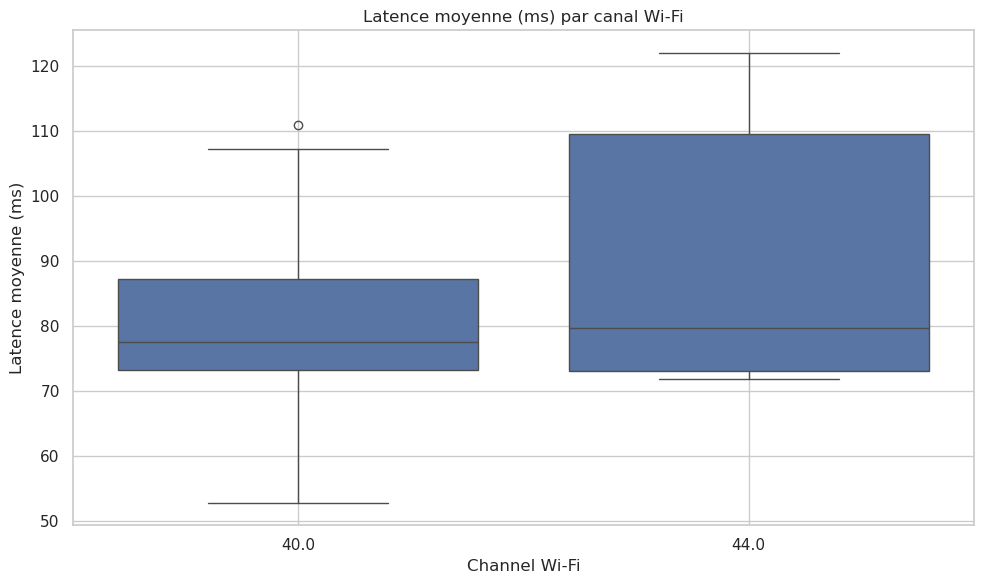

Canaux présents dans le sous-ensemble filtré : [40. 44.]
Canaux disponibles dans le dataset : [36. 40. 44. 48.]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("wifi_dataset_with_server.csv")

#  Nouveau filtrage basé sur les vraies valeurs
filtered_df = df[
    (df["bandwidth_mhz"] == 40) &
    (df["tx_power_dbm"] == 23) &
    (df["proto"] == "UDP") &
    (df["udp_rate"] == "10M")
]

# Tracer la latence moyenne par canal Wi-Fi
plt.figure(figsize=(10, 6))
sns.boxplot(x="channel", y="latency_avg_ms", data=filtered_df)
plt.title("Latence moyenne (ms) par canal Wi-Fi")
plt.xlabel("Channel Wi-Fi")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Voir tous les canaux présents après filtrage
print("Canaux présents dans le sous-ensemble filtré :", filtered_df["channel"].unique())

# Voir tous les canaux présents dans le dataset complet
print("Canaux disponibles dans le dataset :", df["channel"].unique())



In [9]:
!pip install seaborn


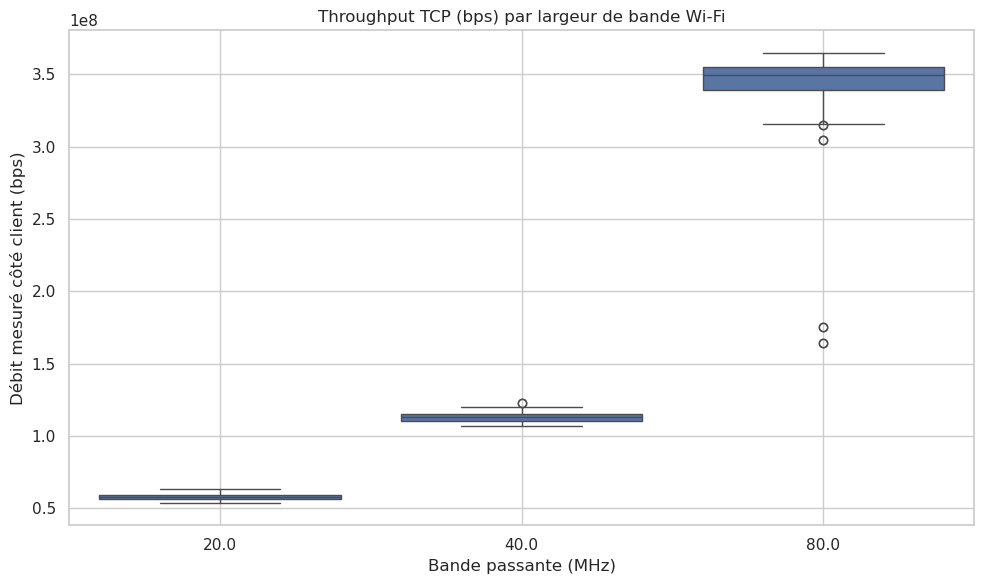

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("wifi_dataset_with_server.csv")

#  Filtrage : TCP uniquement, avec même puissance
filtered_df_tcp = df[
    (df["proto"] == "TCP") &
    (df["tx_power_dbm"] == 23)
]

#  Tracer le throughput par bande passante
plt.figure(figsize=(10, 6))
sns.boxplot(x="bandwidth_mhz", y="throughput_bps", data=filtered_df_tcp)
plt.title("Throughput TCP (bps) par largeur de bande Wi-Fi")
plt.xlabel("Bande passante (MHz)")
plt.ylabel("Débit mesuré côté client (bps)")
plt.grid(True)
plt.tight_layout()
plt.show()


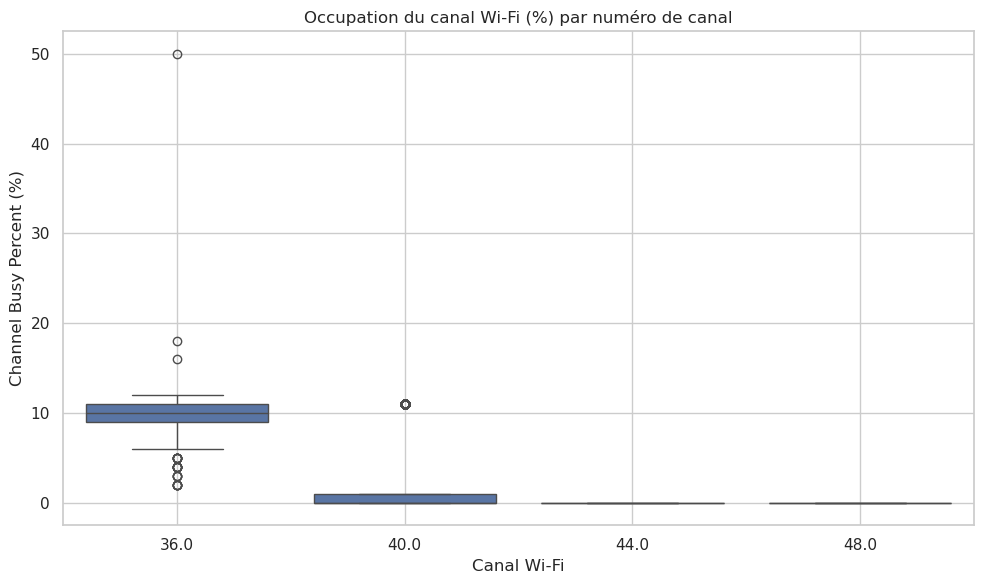

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("wifi_dataset_with_server.csv")

#  Boxplot du taux d'occupation par canal
plt.figure(figsize=(10, 6))
sns.boxplot(x="channel", y="channel_busy_percent", data=df)
plt.title("Occupation du canal Wi-Fi (%) par numéro de canal")
plt.xlabel("Canal Wi-Fi")
plt.ylabel("Channel Busy Percent (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import scipy.stats as st

df_lat = df[(df.bandwidth_mhz==40) & (df.tx_power_dbm==23) &
            (df.proto=="UDP") & (df.udp_rate=="10M")]

#Compare channel‑busy between 40 & 44
print(df_lat.groupby("channel")["channel_busy_percent"].describe())

# Quick t‑test on latency
lat40 = df_lat[df_lat.channel==40]["latency_avg_ms"]
lat44 = df_lat[df_lat.channel==44]["latency_avg_ms"]
print("p‑value latency:", st.ttest_ind(lat40, lat44, equal_var=False).pvalue)


         count  mean       std  min  25%  50%   75%   max
channel                                                  
40.0      10.0   4.4  5.680376  0.0  0.0  0.0  11.0  11.0
44.0      12.0   0.0  0.000000  0.0  0.0  0.0   0.0   0.0
p‑value latency: 0.2569603931718304


In [6]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 18.9 MB/s eta 0:00:00 0:00:01


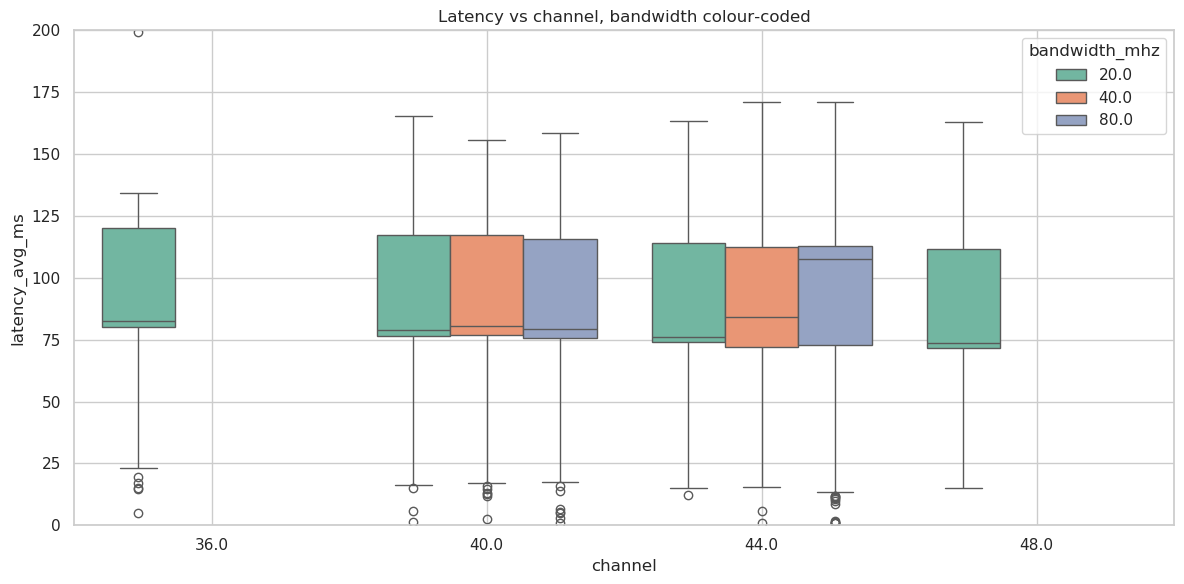

                        sum_sq      df         F    PR(>F)
C(channel)        8.135395e+03     3.0  3.612658  0.012721
C(bandwidth_mhz)  2.891586e+03     2.0  1.926086  0.145868
Residual          2.703047e+06  3601.0       NaN       NaN


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

plt.figure(figsize=(12,6))
sns.boxplot(
    x="channel",
    y="latency_avg_ms",
    hue="bandwidth_mhz",     
    data=df,                
    palette="Set2"
)
plt.ylim(0,200)
plt.title("Latency vs channel, bandwidth colour‑coded")
plt.grid(True)
plt.tight_layout()
plt.show()


model = smf.ols("latency_avg_ms ~ C(channel) + C(bandwidth_mhz)", data=df).fit()
print(sm.stats.anova_lm(model, typ=2))


                                   sum_sq      df           F    PR(>F)
C(channel)                   4.214127e+02     3.0    0.187344  0.829167
C(bandwidth_mhz)            -2.437496e+05     2.0 -162.542339  1.000000
C(channel):C(bandwidth_mhz)  1.203324e+03     6.0    0.267475  0.605062
Residual                     2.698543e+06  3599.0         NaN       NaN


/home/chaabenm/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/chaabenm/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/chaabenm/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '


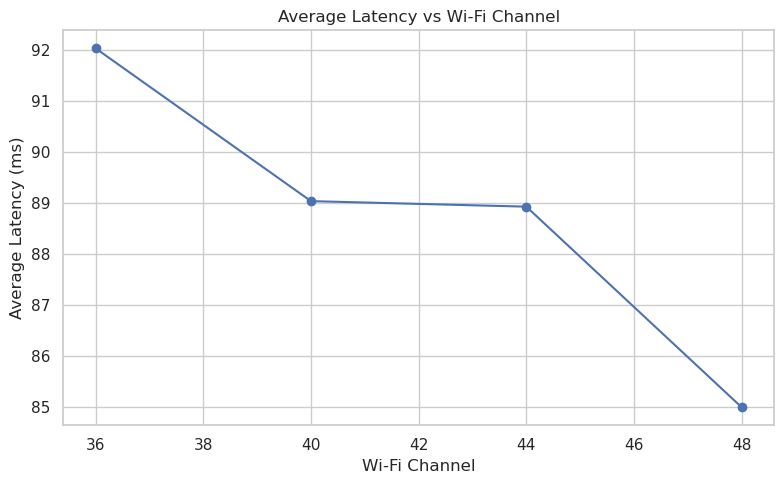

In [17]:
import matplotlib.pyplot as plt

grouped = df.groupby("channel")["latency_avg_ms"].mean().reset_index()

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(grouped["channel"], grouped["latency_avg_ms"], marker='o')
plt.xlabel("Wi-Fi Channel")
plt.ylabel("Average Latency (ms)")
plt.title("Average Latency vs Wi-Fi Channel")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
!pip install statsmodels


In [22]:
!pip install statsmodels


RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

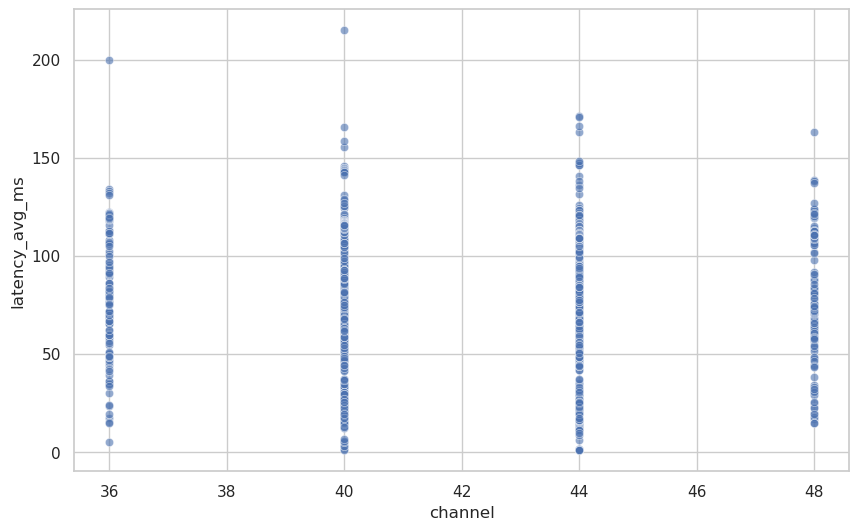

In [24]:
!pip install statsmodels


In [26]:
import statsmodels.api as sm
print(sm.__version__)


0.14.5


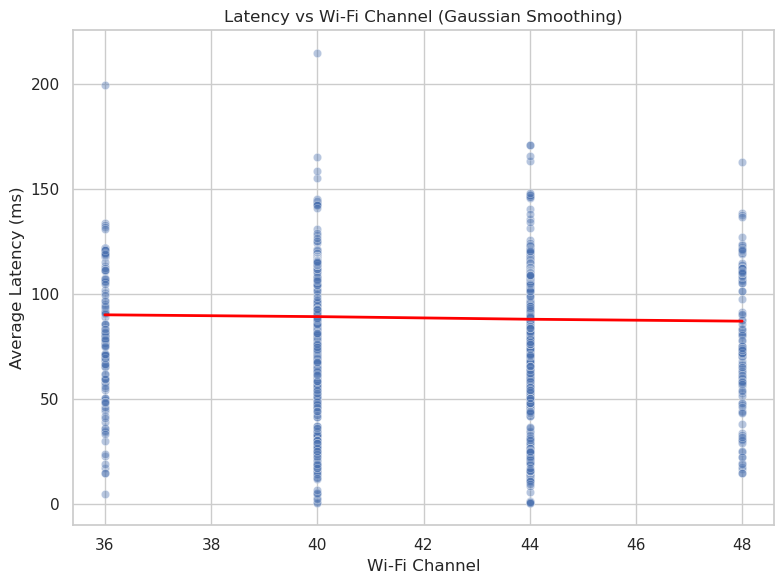

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(8, 6))

# Scatter des points
sns.scatterplot(data=df, x="channel", y="latency_avg_ms", alpha=0.4)

# Moyenne par canal
mean_latency = df.groupby("channel")["latency_avg_ms"].mean()
channels = mean_latency.index
smoothed_latency = gaussian_filter1d(mean_latency.values, sigma=1.5)

# Ajout d'une courbe lissée sans statsmodels
plt.plot(channels, smoothed_latency, color="red", linewidth=2)

plt.xlabel("Wi-Fi Channel")
plt.ylabel("Average Latency (ms)")
plt.title("Latency vs Wi-Fi Channel (Gaussian Smoothing)")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_11342/3028738412.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


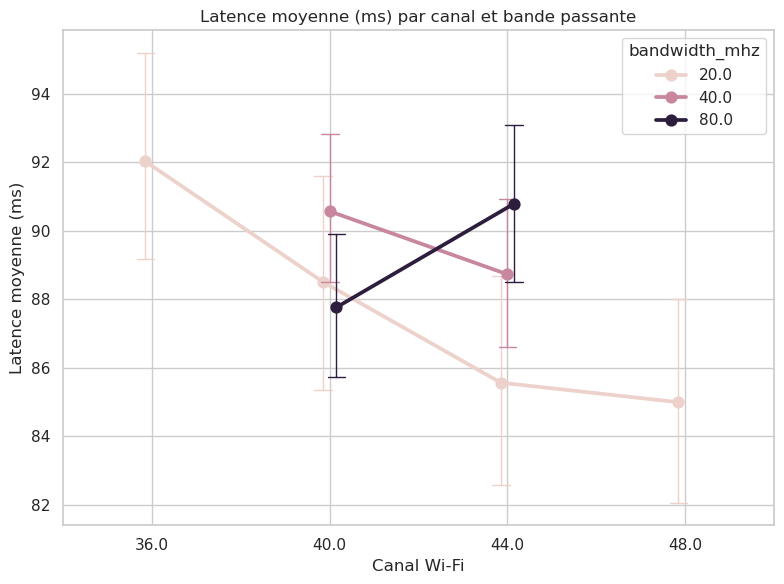

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.pointplot(
    data=df,
    x="channel", y="latency_avg_ms",
    hue="bandwidth_mhz", dodge=True, markers="o", capsize=.1, errwidth=1
)
plt.title("Latence moyenne (ms) par canal et bande passante")
plt.xlabel("Canal Wi-Fi")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()


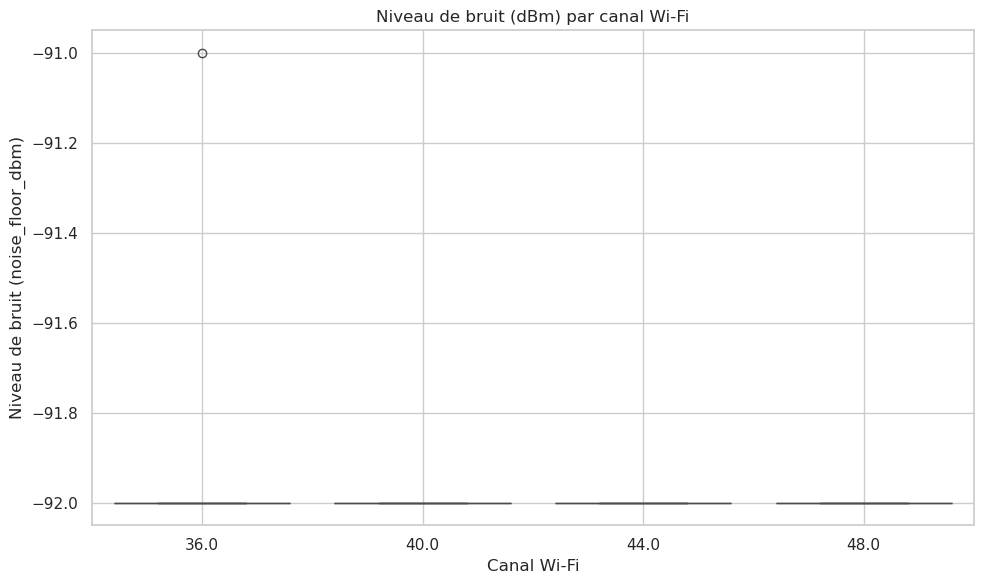

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Charger les données
df = pd.read_csv("wifi_dataset_with_server.csv")

# Tracer le bruit par canal
plt.figure(figsize=(10, 6))
sns.boxplot(x="channel", y="noise_floor_dbm", data=df)
plt.title("Niveau de bruit (dBm) par canal Wi-Fi")
plt.xlabel("Canal Wi-Fi")
plt.ylabel("Niveau de bruit (noise_floor_dbm)")
plt.grid(True)
plt.tight_layout()
plt.show()


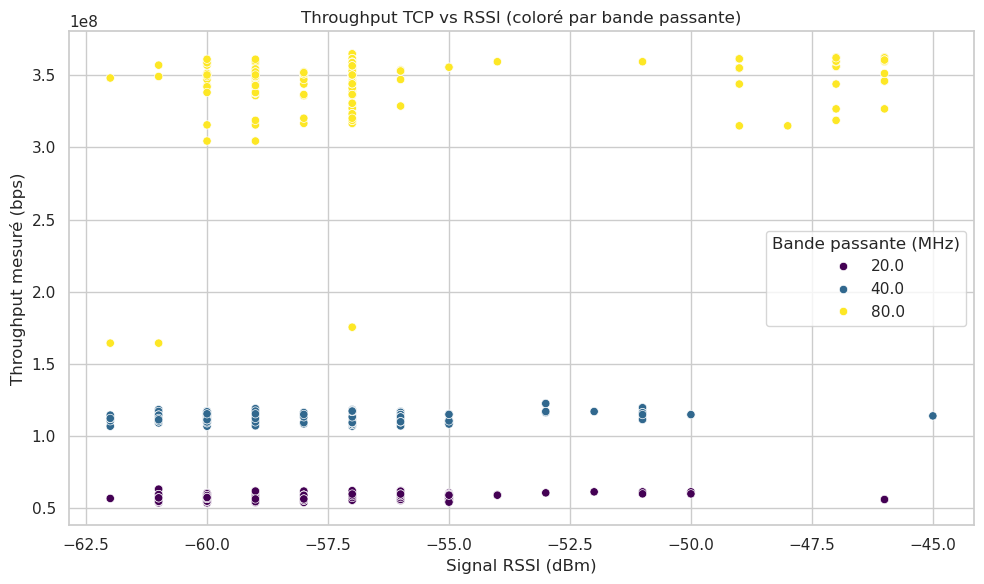

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Charger les données
df = pd.read_csv("wifi_dataset_with_server.csv")

# Filtrage : TCP uniquement
filtered_df = df[
    (df["proto"] == "TCP") &
    (df["tx_power_dbm"] == 23)
]

# ✅ Scatter plot avec hue
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="bandwidth_mhz",
    palette="viridis",
    data=filtered_df
)
plt.title("Throughput TCP vs RSSI (coloré par bande passante)")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Throughput mesuré (bps)")
plt.legend(title="Bande passante (MHz)")
plt.grid(True)
plt.tight_layout()
plt.show()


/home/chaabenm/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


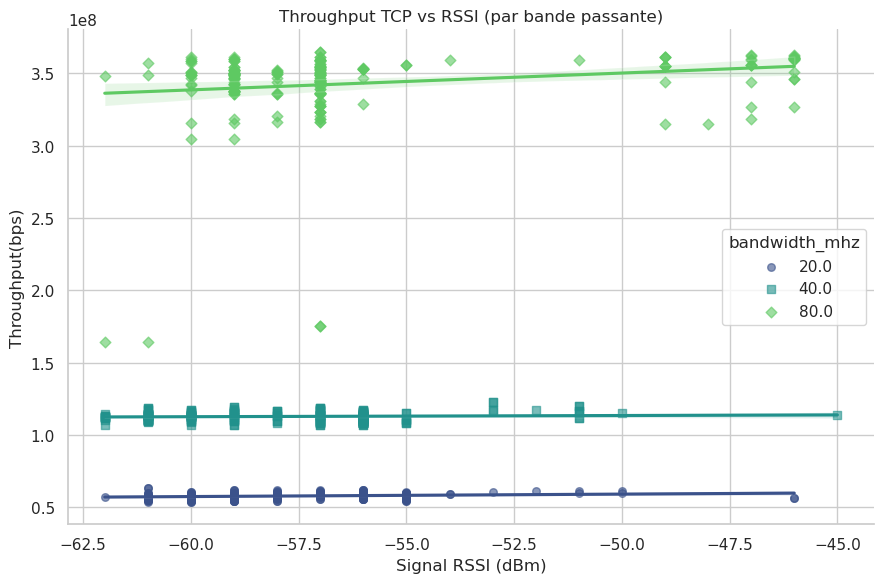

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement du dataset
df = pd.read_csv("wifi_dataset_with_server.csv")

# Filtrer : TCP uniquement + puissance TX fixe
filtered_df = df[
    (df["proto"] == "TCP") &
    (df["tx_power_dbm"] == 23)
]

# Tracé avec sns.lmplot (regression + couleurs par bande passante)
sns.lmplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="bandwidth_mhz",
    data=filtered_df,
    palette="viridis",
    height=6,
    aspect=1.5,
    scatter_kws={"s": 30, "alpha": 0.6},  # taille des points
    markers=["o", "s", "D"],              # symboles différents
    legend_out=False,
    ci=95                                 # intervalle de confiance
)

plt.title("Throughput TCP vs RSSI (par bande passante)")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Throughput(bps)")
plt.grid(True)
plt.tight_layout()
plt.show()


/home/chaabenm/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


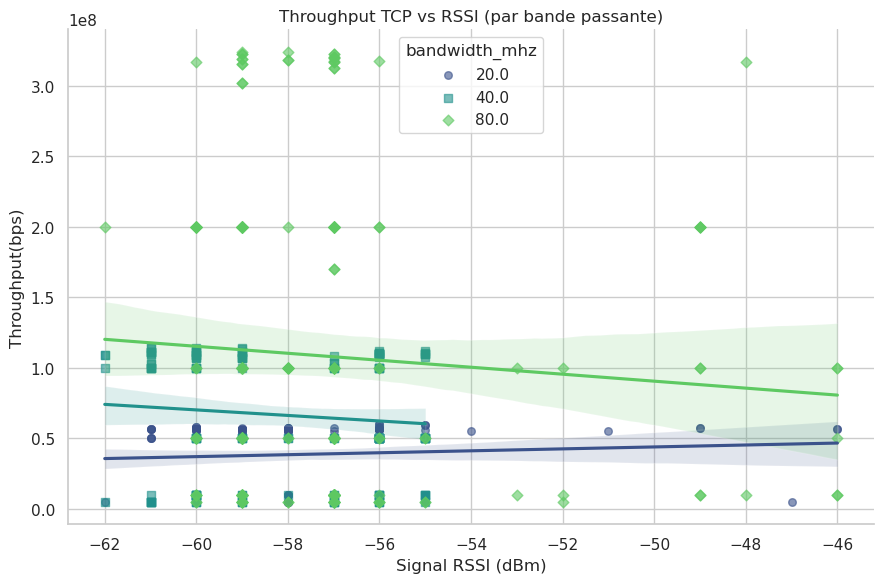

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement du dataset
df = pd.read_csv("wifi_dataset_with_server.csv")

# Filtrer : TCP uniquement + puissance TX fixe
filtered_df = df[
    (df["proto"] == "UDP") &
    (df["tx_power_dbm"] == 23)
]

# Tracé avec sns.lmplot (regression + couleurs par bande passante)
sns.lmplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="bandwidth_mhz",
    data=filtered_df,
    palette="viridis",
    height=6,
    aspect=1.5,
    scatter_kws={"s": 30, "alpha": 0.6},  # taille des points
    markers=["o", "s", "D"],              # symboles différents
    legend_out=False,
    ci=95                                 # intervalle de confiance
)

plt.title("Throughput TCP vs RSSI (par bande passante)")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Throughput(bps)")
plt.grid(True)
plt.tight_layout()
plt.show()


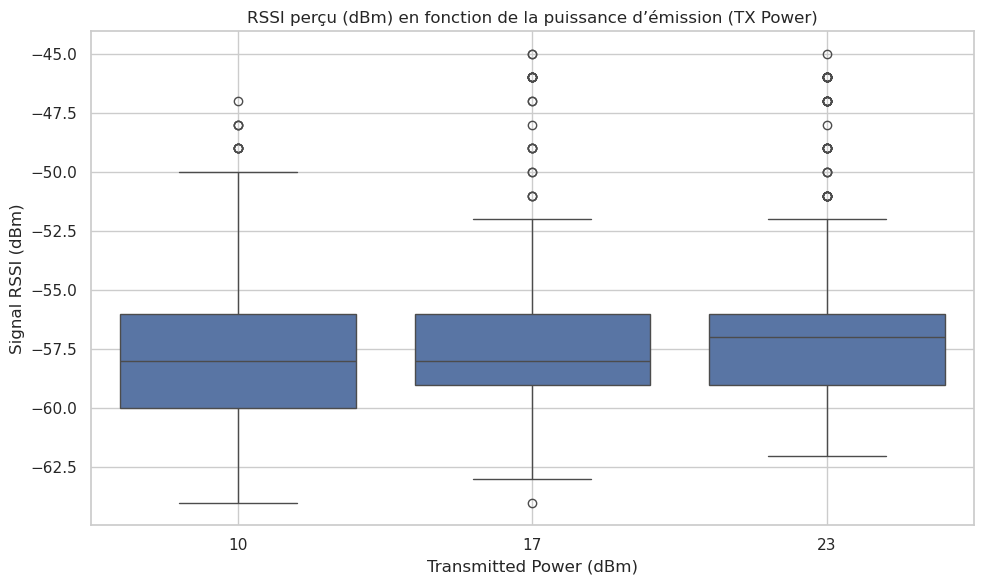

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Charger les données
df = pd.read_csv("wifi_dataset_with_server.csv")

# Filtrage TCP (ou sans filtre si tu veux tout inclure)
df_tcp = df[df["proto"] == "TCP"]

# Boxplot du RSSI selon la puissance d’émission
plt.figure(figsize=(10, 6))
sns.boxplot(x="tx_power_dbm", y="signal_rssi_dbm", data=df_tcp)
plt.title("RSSI perçu (dBm) en fonction de la puissance d’émission (TX Power)")
plt.xlabel("Transmitted Power (dBm)")
plt.ylabel("Signal RSSI (dBm)")
plt.grid(True)
plt.tight_layout()
plt.show()


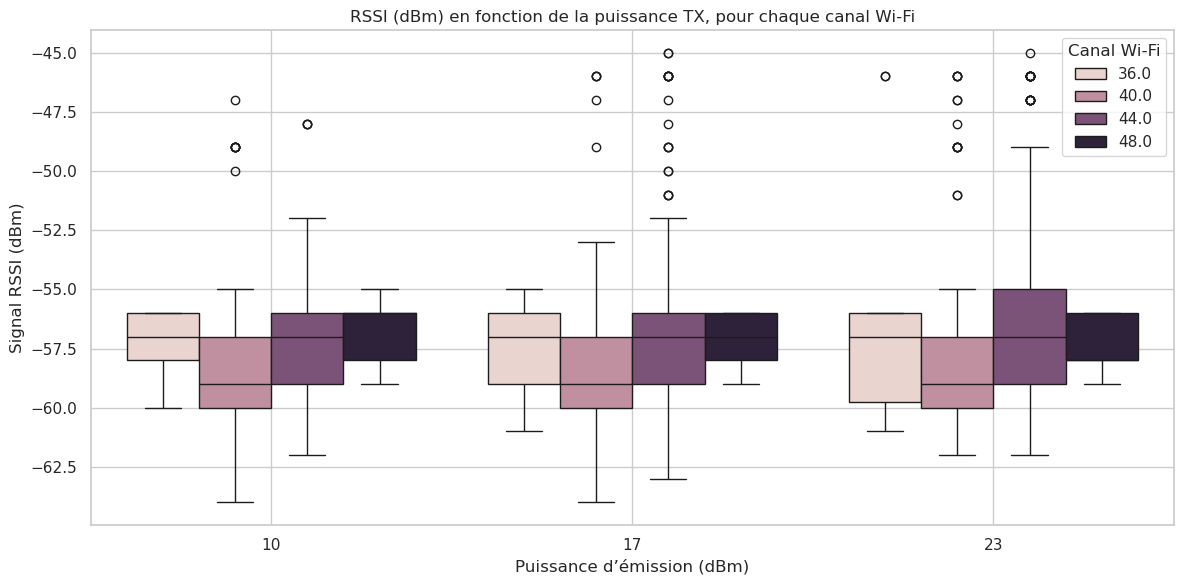

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Charger les données
df = pd.read_csv("wifi_dataset_with_server.csv")

# Filtrage TCP uniquement
df_tcp = df[df["proto"] == "TCP"]

# Tracer le RSSI par puissance d'émission, séparément pour chaque canal
plt.figure(figsize=(12, 6))
sns.boxplot(x="tx_power_dbm", y="signal_rssi_dbm", hue="channel", data=df_tcp)
plt.title("RSSI (dBm) en fonction de la puissance TX, pour chaque canal Wi-Fi")
plt.xlabel("Puissance d’émission (dBm)")
plt.ylabel("Signal RSSI (dBm)")
plt.legend(title="Canal Wi-Fi")
plt.grid(True)
plt.tight_layout()
plt.show()


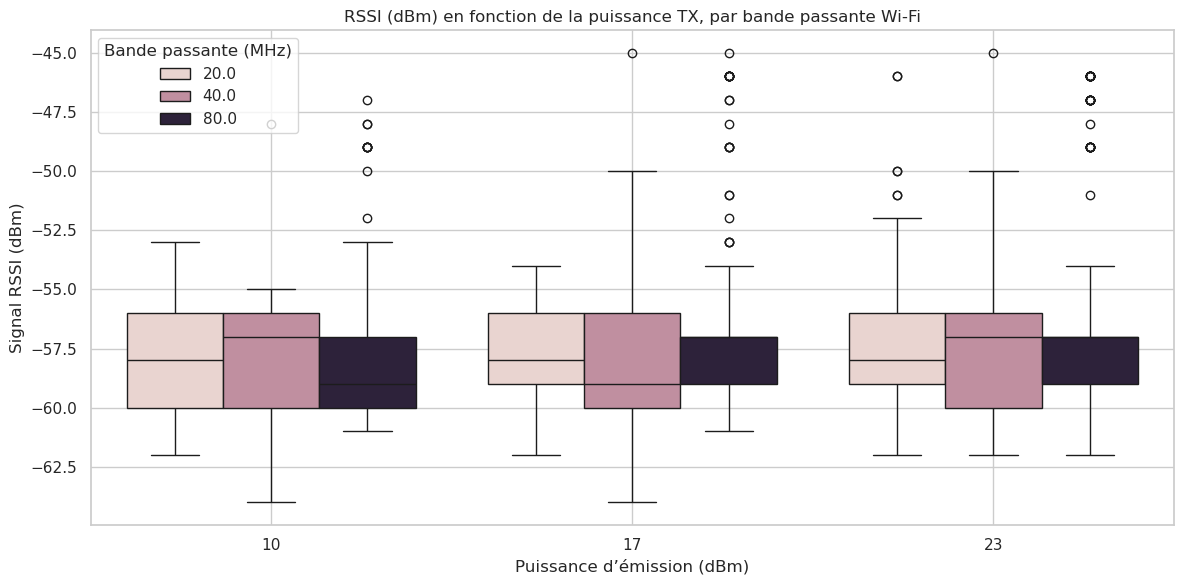

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv("wifi_dataset_with_server.csv")

# iltrer TCP seulement
df_tcp = df[df["proto"] == "TCP"]

# Tracer le RSSI par puissance TX, séparément par bande passante
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="tx_power_dbm",
    y="signal_rssi_dbm",
    hue="bandwidth_mhz",
    data=df_tcp
)
plt.title("RSSI (dBm) en fonction de la puissance TX, par bande passante Wi-Fi")
plt.xlabel("Puissance d’émission (dBm)")
plt.ylabel("Signal RSSI (dBm)")
plt.legend(title="Bande passante (MHz)")
plt.grid(True)
plt.tight_layout()
plt.show()


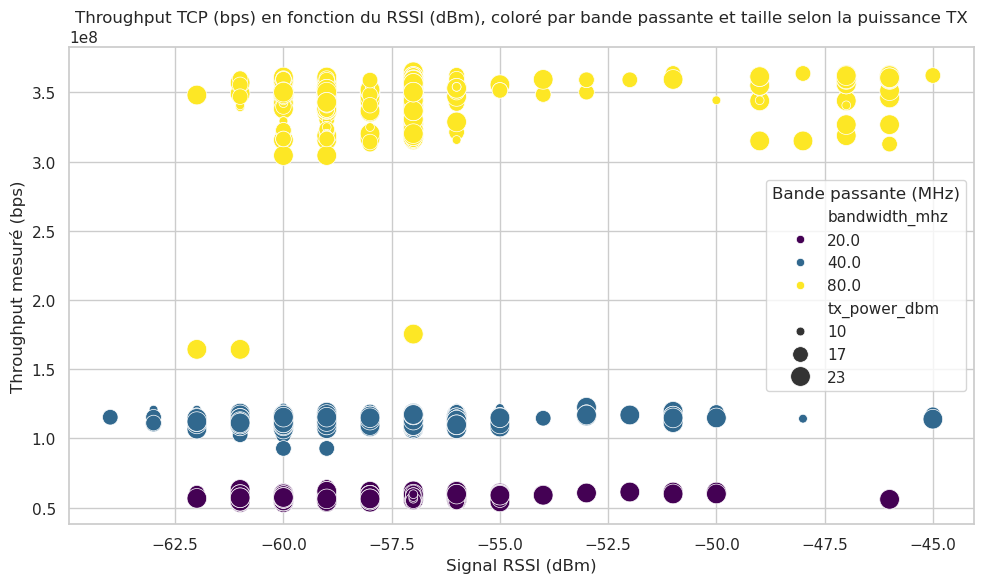

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="bandwidth_mhz",       # Couleur = bande passante
    size="tx_power_dbm",       # Taille = puissance d’émission
    sizes=(40, 200),           # Ajuste la taille minimale et maximale
    palette="viridis",         # Palette de couleurs
    data=df[df["proto"] == "TCP"]
)
plt.title("Throughput TCP (bps) en fonction du RSSI (dBm), coloré par bande passante et taille selon la puissance TX")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Throughput mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Bande passante (MHz)")
plt.show()


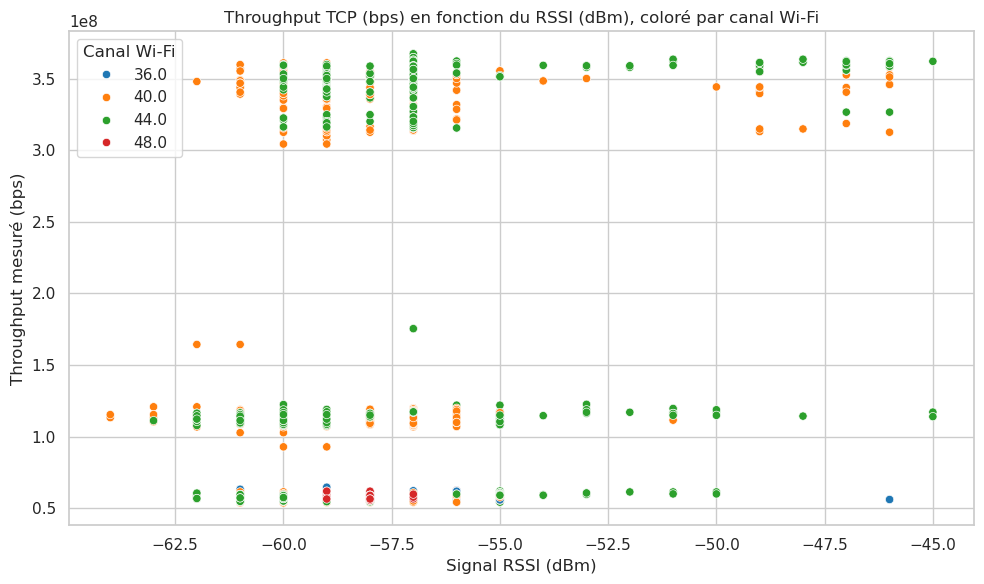

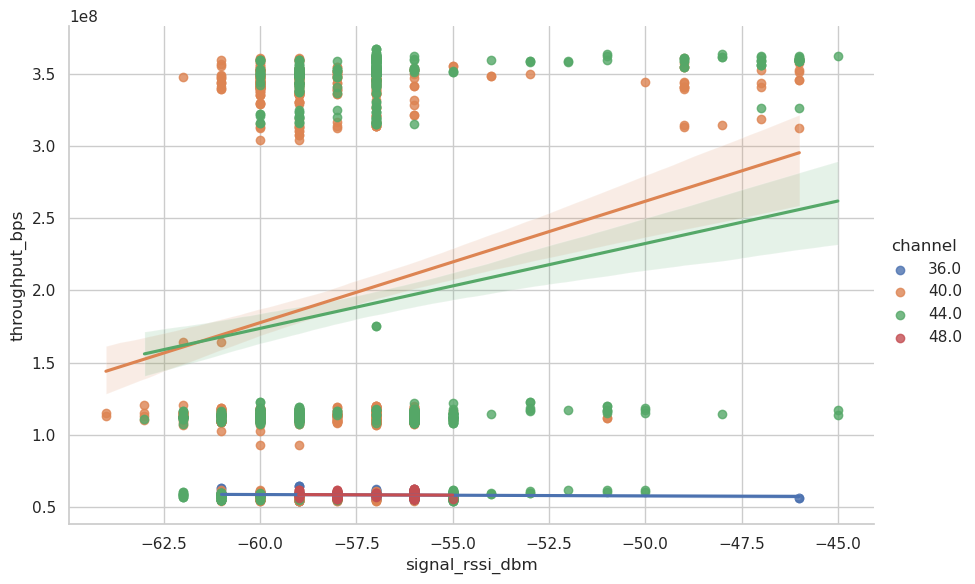

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer TCP uniquement
df_tcp = df[df["proto"] == "TCP"]

# Scatter plot : RSSI vs Throughput, coloré par canal Wi-Fi
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="channel",
    data=df_tcp,
    palette="tab10"  # Palette de couleurs pour distinguer les canaux
)
plt.title("Throughput TCP (bps) en fonction du RSSI (dBm), coloré par canal Wi-Fi")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Throughput mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Canal Wi-Fi")
plt.show()
sns.lmplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="channel",
    data=df[df["proto"] == "TCP"],
    height=6,
    aspect=1.5
)



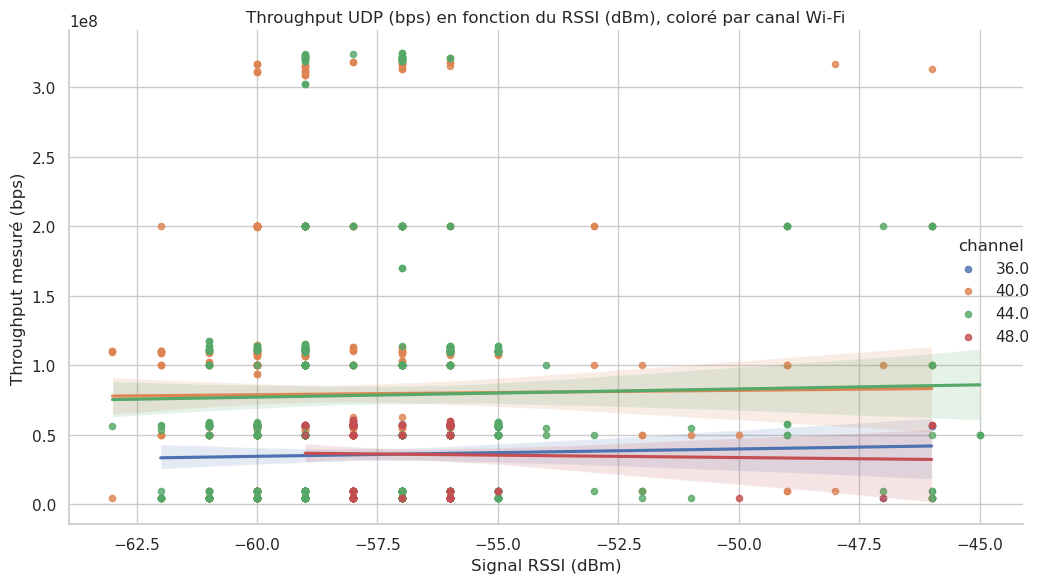

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer uniquement UDP
df_udp = df[df["proto"] == "UDP"]

# Tracer lmplot : RSSI vs Throughput, coloré par canal
sns.lmplot(
    data=df_udp,
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="channel",              # Chaque canal en couleur
    scatter_kws={"s": 20},      # Taille des points
    height=6,
    aspect=1.6,
    markers="o",
    ci=95                       # Intervalle de confiance
)

plt.title("Throughput UDP (bps) en fonction du RSSI (dBm), coloré par canal Wi-Fi")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Throughput mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.show()


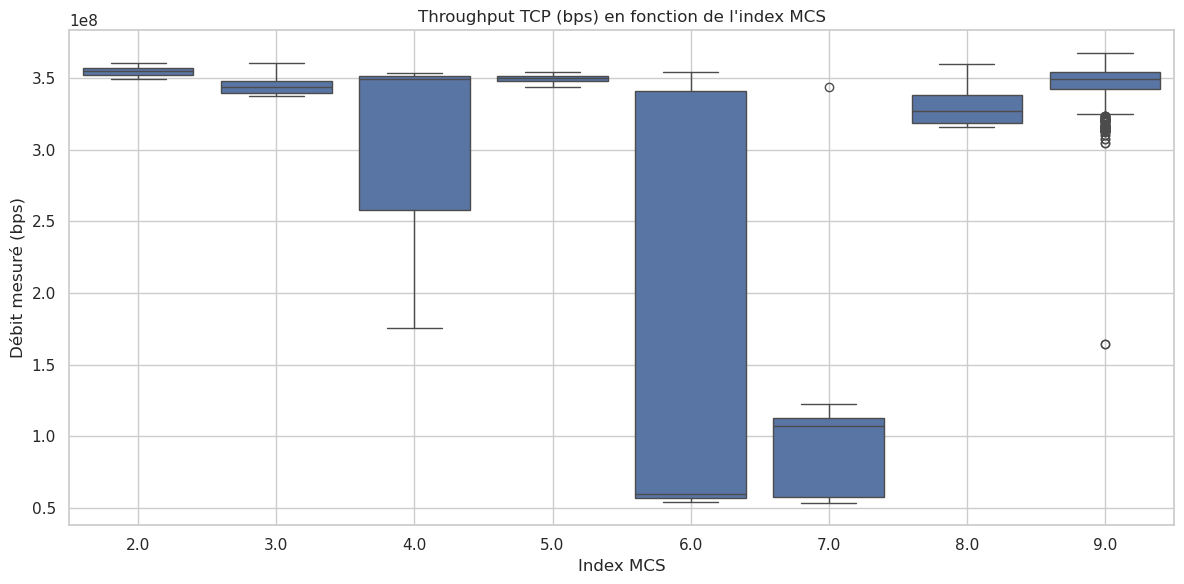

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer les paquets TCP si nécessaire
df_tcp = df[df["proto"] == "TCP"]

# Tracer le throughput en fonction de l'index MCS (TCP uniquement)
plt.figure(figsize=(12, 6))
sns.boxplot(x="mcs_index", y="throughput_bps", data=df_tcp)
plt.title("Throughput TCP (bps) en fonction de l'index MCS")
plt.xlabel("Index MCS")
plt.ylabel("Débit mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.show()



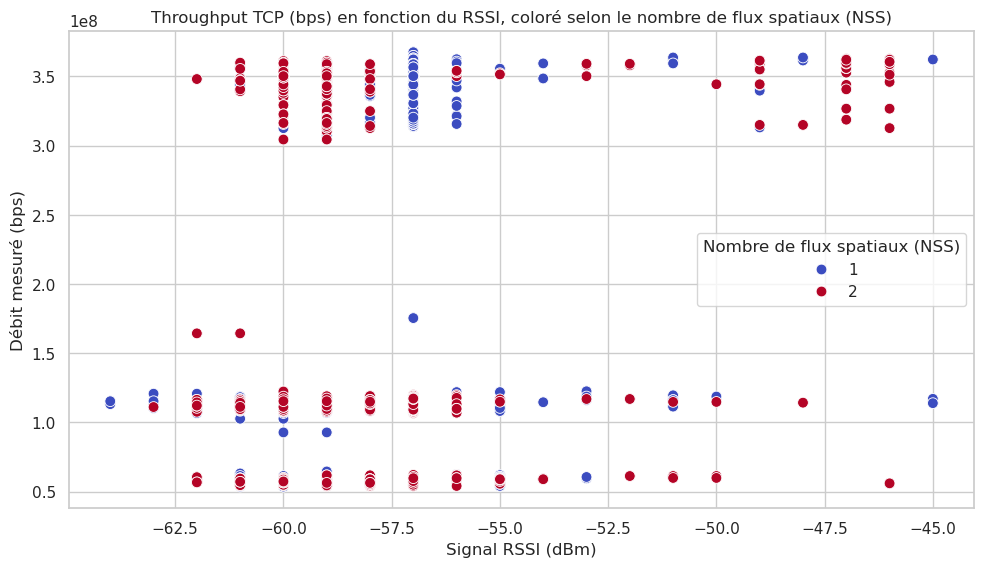

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer TCP uniquement
df_tcp = df[df["proto"] == "TCP"]

# Tracer le throughput TCP en fonction du RSSI, coloré par NSS
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="signal_rssi_dbm",
    y="throughput_bps",
    hue="nss",
    data=df_tcp,
    palette="coolwarm",
    s=60
)

plt.title("Throughput TCP (bps) en fonction du RSSI, coloré selon le nombre de flux spatiaux (NSS)")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Débit mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Nombre de flux spatiaux (NSS)")
plt.show()


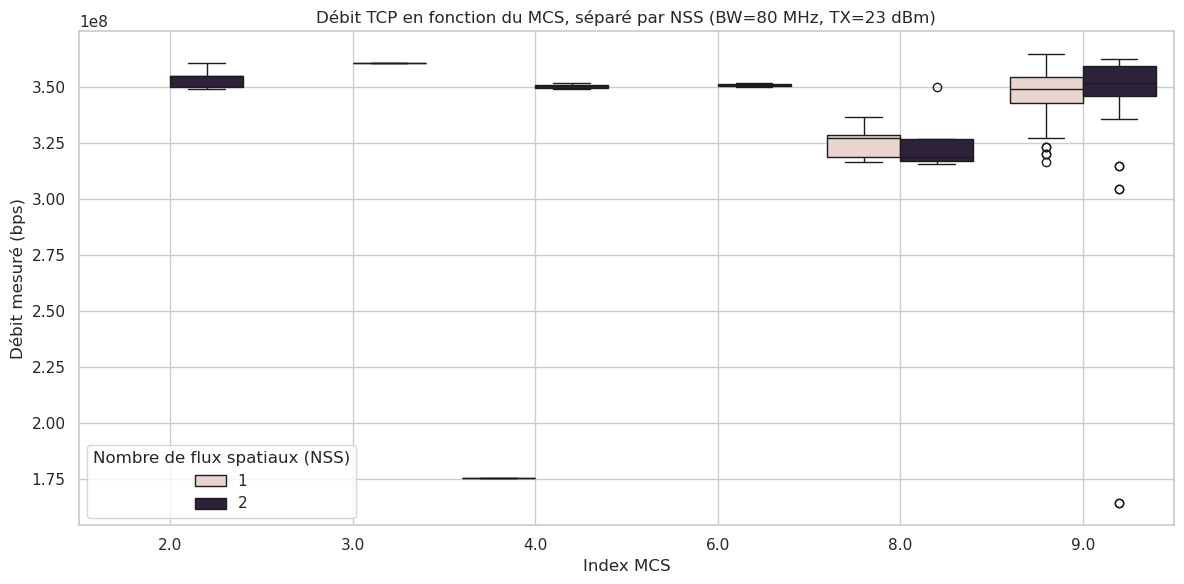

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_tcp[
        (df_tcp["bandwidth_mhz"] == 80) & 
        (df_tcp["tx_power_dbm"] == 23)
    ],
    x="mcs_index",
    y="throughput_bps",
    hue="nss"
)

plt.title("Débit TCP en fonction du MCS, séparé par NSS (BW=80 MHz, TX=23 dBm)")
plt.xlabel("Index MCS")
plt.ylabel("Débit mesuré (bps)")
plt.grid(True)
plt.legend(title="Nombre de flux spatiaux (NSS)")
plt.tight_layout()
plt.show()


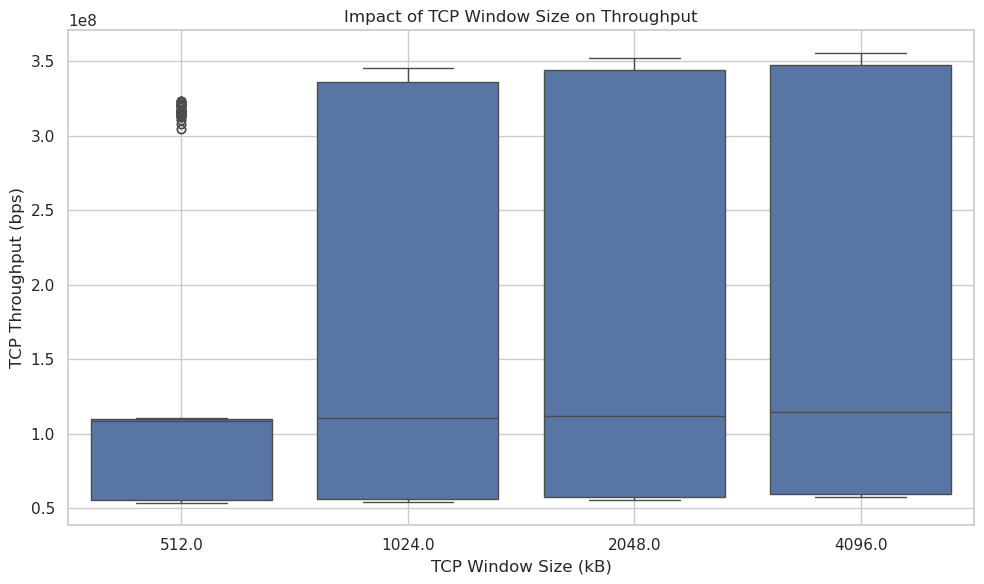

In [31]:
def convert_window_to_bytes(val):
    if isinstance(val, str):
        val = val.upper().replace("B", "").strip()
        try:
            if val.endswith("K"):
                return int(val[:-1]) * 1024
            elif val.endswith("M"):
                return int(val[:-1]) * 1024 * 1024
        except ValueError:
            return None
    return None  # NaN ou valeurs non convertibles

# Conversion et ajout des colonnes
df["tcp_window_bytes"] = df["tcp_window"].apply(convert_window_to_bytes)
df["tcp_window_kB"] = df["tcp_window_bytes"] / 1024

# filtrer les valeurs valides
df_plot = df[df["tcp_window_kB"].notna()]

# Boxplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Tri des catégories pour un affichage logique
order = sorted(df_plot["tcp_window_kB"].dropna().unique())

sns.boxplot(x="tcp_window_kB", y="throughput_bps", data=df_plot, order=order)

plt.title("Impact of TCP Window Size on Throughput")
plt.xlabel("TCP Window Size (kB)")
plt.ylabel("TCP Throughput (bps)")
plt.grid(True)
plt.tight_layout()
plt.show()


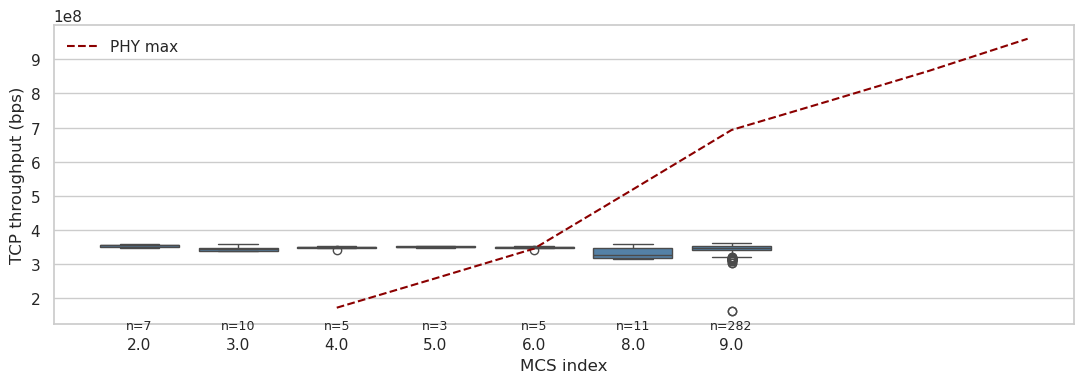

In [28]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# ---------------------------------------------
# Filtrage (80 MHz, NSS=2, TCP)
sel = (df["bandwidth_mhz"] == 80) & (df["nss"] == 2) & (df["proto"] == "TCP")
d = df.loc[sel, ["mcs_index", "throughput_bps"]]

# Box‑plot
plt.figure(figsize=(11,4))
ax = sns.boxplot(data=d, x="mcs_index", y="throughput_bps", color="steelblue")
ax.set_xlabel("MCS index"); ax.set_ylabel("TCP throughput (bps)")

# 3) n = effectif sous chaque boîte
counts = d.groupby("mcs_index").size()
for tick, n in zip(ax.get_xticks(), counts):
    ax.text(tick, ax.get_ylim()[0] - .04*ax.get_ylim()[1], f"n={n}", 
            ha="center", va="top", fontsize=9)

# 4) Courbe PHY nominal
phy_tbl = {2:173, 3:259, 4:346, 5:519, 6:693, 7:779, 8:866, 9:960}  # Mb/s
mcs, phy = zip(*phy_tbl.items())
plt.plot(mcs, [p*1e6 for p in phy], '--', lw=1.5, color='darkred', 
         label="PHY max")

plt.legend(frameon=False); plt.tight_layout()
plt.show()


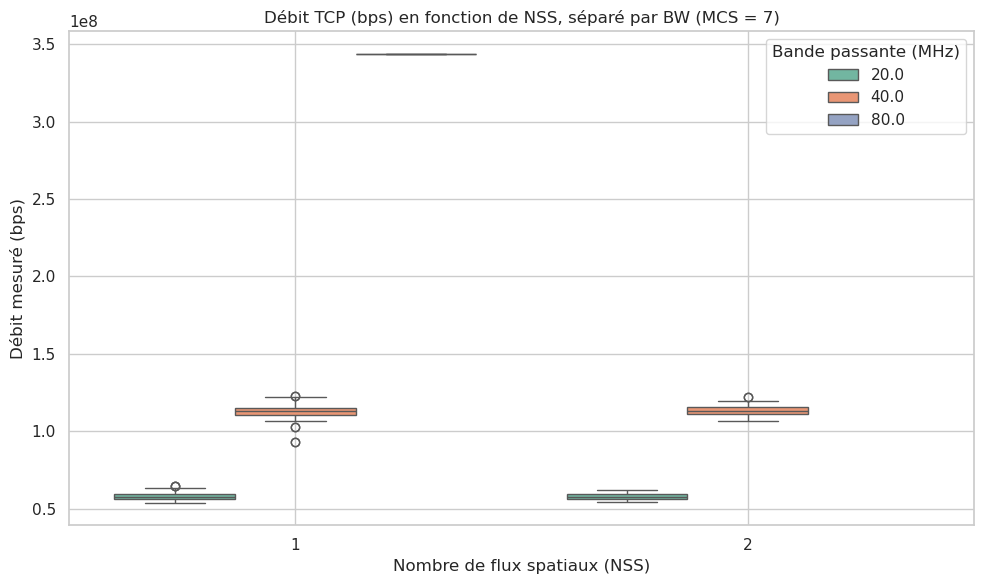

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer les données TCP avec MCS = 7
df_tcp_mcs7 = df_tcp[df_tcp["mcs_index"] == 7]

# Tracer le débit mesuré en fonction de NSS, coloré par bandwidth_mhz
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="nss",
    y="throughput_bps",
    hue="bandwidth_mhz",
    data=df_tcp_mcs7,
    palette="Set2"
)

plt.title("Débit TCP (bps) en fonction de NSS, séparé par BW (MCS = 7)")
plt.xlabel("Nombre de flux spatiaux (NSS)")
plt.ylabel("Débit mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Bande passante (MHz)")
plt.show()


/tmp/ipykernel_4526/2622720444.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="proto", y="throughput_bps", data=df_proto, palette="Set3")


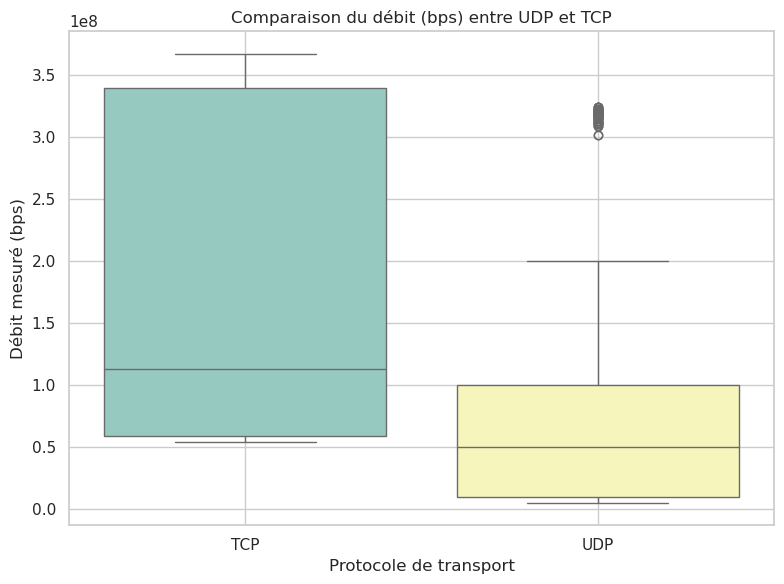

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ne garder que les lignes avec proto bien défini
df_proto = df[df['proto'].isin(['TCP', 'UDP'])]

# Tracer un boxplot du débit en fonction du protocole
plt.figure(figsize=(8, 6))
sns.boxplot(x="proto", y="throughput_bps", data=df_proto, palette="Set3")

plt.title("Comparaison du débit (bps) entre UDP et TCP")
plt.xlabel("Protocole de transport")
plt.ylabel("Débit mesuré (bps)")
plt.grid(True)
plt.tight_layout()
plt.show()


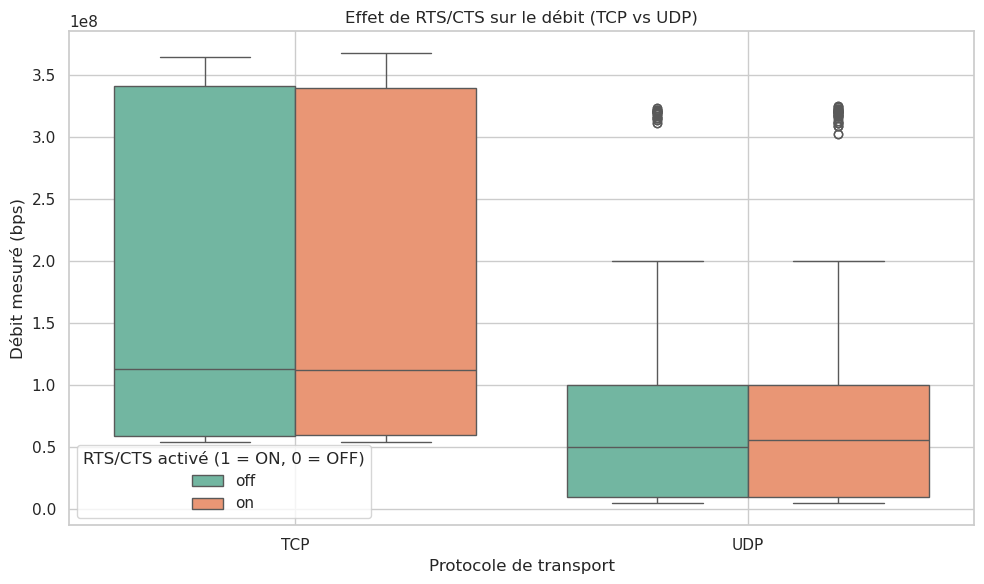

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x="proto", y="throughput_bps", hue="rts_cts", data=df_proto, palette="Set2")

plt.title("Effet de RTS/CTS sur le débit (TCP vs UDP)")
plt.xlabel("Protocole de transport")
plt.ylabel("Débit mesuré (bps)")
plt.legend(title="RTS/CTS activé (1 = ON, 0 = OFF)")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4526/2851795534.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


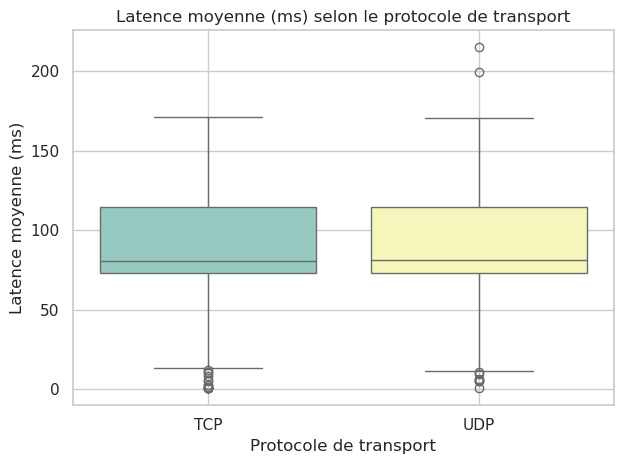

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x="proto", 
    y="latency_avg_ms", 
    data=df, 
    palette="Set3"
)
plt.title("Latence moyenne (ms) selon le protocole de transport")
plt.xlabel("Protocole de transport")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()


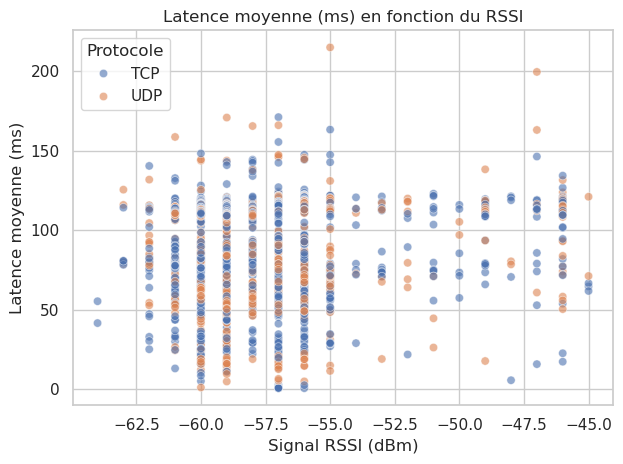

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(
    x="signal_rssi_dbm", 
    y="latency_avg_ms", 
    data=df, 
    hue="proto", 
    alpha=0.6
)
plt.title("Latence moyenne (ms) en fonction du RSSI")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Protocole")
plt.show()


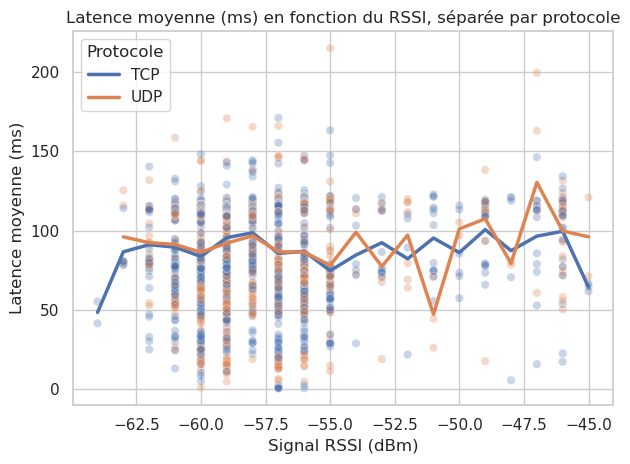

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Scatter plot pour garder la densité des points visibles
sns.scatterplot(
    x="signal_rssi_dbm",
    y="latency_avg_ms",
    hue="proto",
    data=df,
    alpha=0.3,
    legend=False  
)

# Ajout de la courbe de moyenne avec lissage 
sns.lineplot(
    x="signal_rssi_dbm",
    y="latency_avg_ms",
    hue="proto",
    data=df,
    estimator="mean",
    errorbar=None,
    linewidth=2.5
)

plt.title("Latence moyenne (ms) en fonction du RSSI, séparée par protocole")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.legend(title="Protocole")
plt.tight_layout()
plt.show()


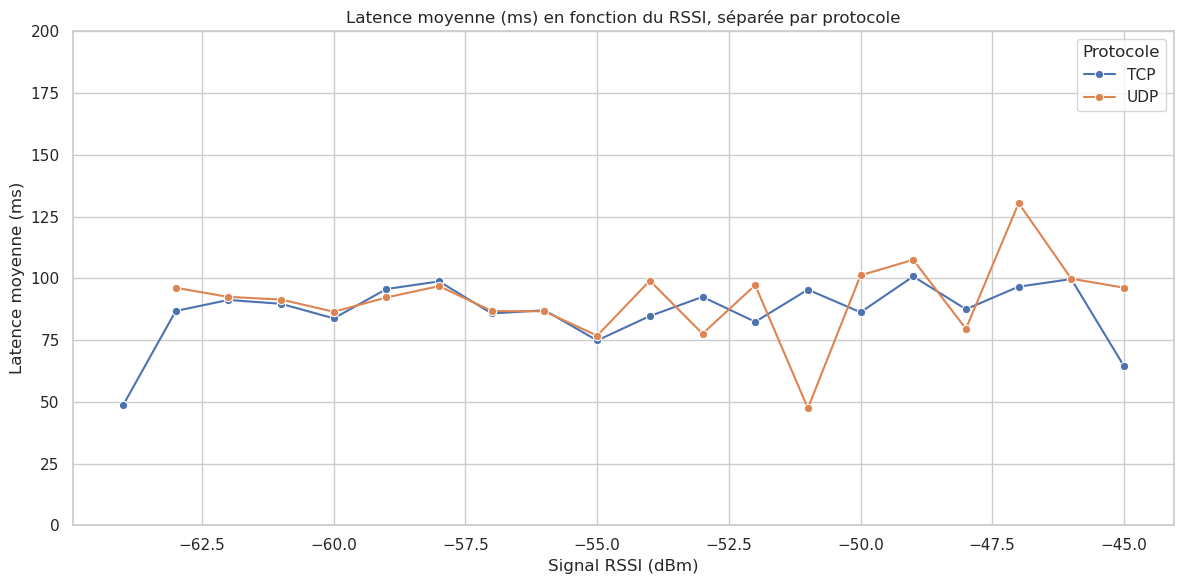

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Création d'une colonne avec RSSI arrondi 
df["rssi_rounded"] = df["signal_rssi_dbm"].round()

# Filtrage pour limiter les valeurs extrêmes
df_filtered = df[df["latency_avg_ms"] <= 200]

# Calcul de la moyenne de latence pour chaque RSSI arrondi et protocole
df_grouped = df_filtered.groupby(["rssi_rounded", "proto"])["latency_avg_ms"].mean().reset_index()

# Tracé
plt.figure(figsize=(12, 6))
sns.lineplot(
    x="rssi_rounded",
    y="latency_avg_ms",
    hue="proto",
    data=df_grouped,
    marker="o"
)

plt.title("Latence moyenne (ms) en fonction du RSSI, séparée par protocole")
plt.xlabel("Signal RSSI (dBm)")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.ylim(0, 200)  
plt.legend(title="Protocole")
plt.tight_layout()
plt.show()


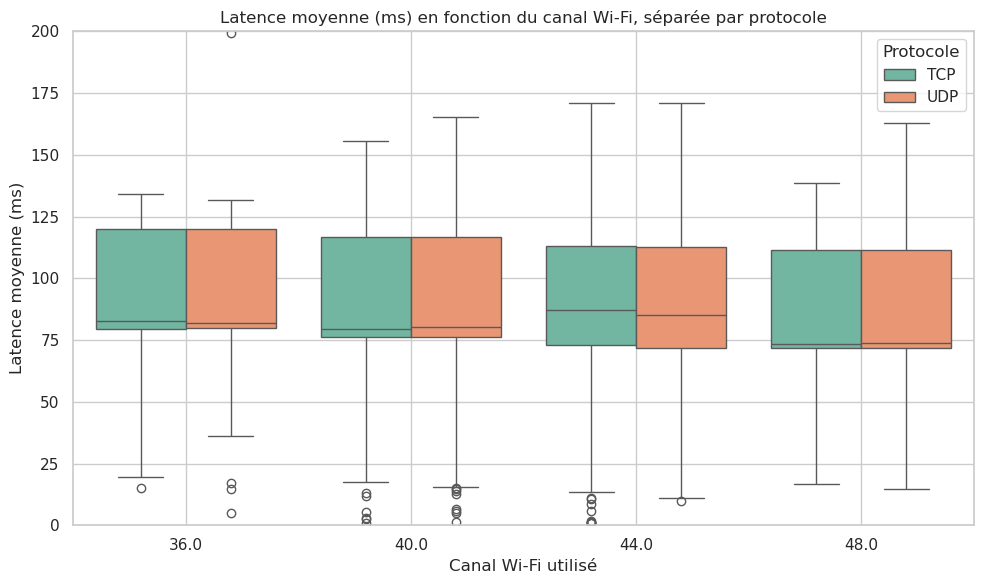

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="channel",
    y="latency_avg_ms",
    hue="proto",  
    data=df,
    palette="Set2"
)

plt.title("Latence moyenne (ms) en fonction du canal Wi-Fi, séparée par protocole")
plt.xlabel("Canal Wi-Fi utilisé")
plt.ylabel("Latence moyenne (ms)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Protocole")
plt.ylim(0, 200)  
plt.show()


/tmp/ipykernel_11342/2039962576.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cw["cw_pair"] = df_cw["cwmin"].astype(str) + "/" + df_cw["cwmax"].astype(str)
/tmp/ipykernel_11342/2039962576.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


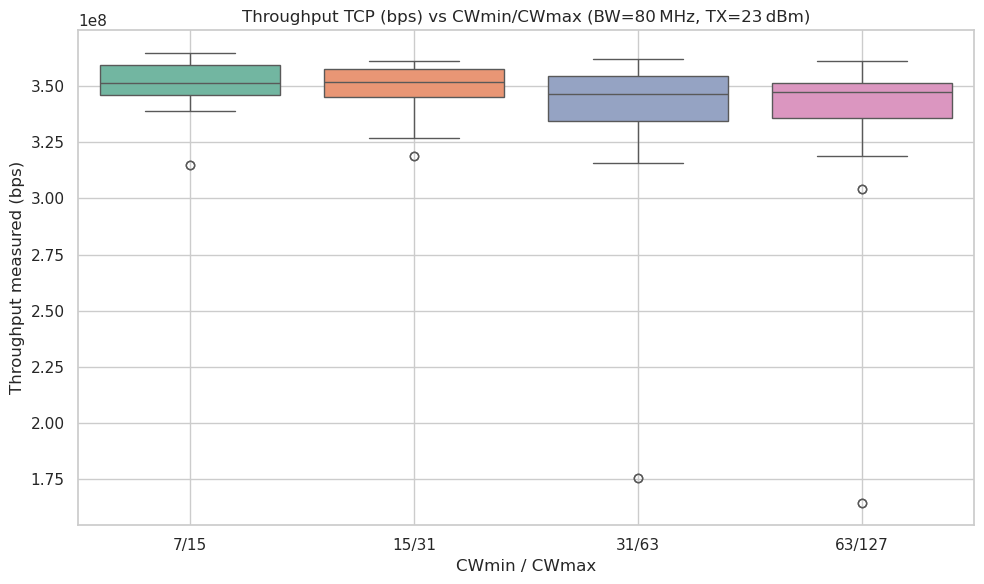

In [12]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot: impact of CWmin / CWmax on throughput
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

df = pd.read_csv("wifi_dataset_with_server.csv")

# filter to a consistent test subset
df_cw = df[
    (df["proto"] == "TCP") &          # keep TCP only 
    (df["bandwidth_mhz"] == 80) &     # fix BW to isolate CW effect
    (df["tx_power_dbm"] == 23)        # fix TX power
]

# Build a readable categorical label “CWmin/CWmax”
df_cw["cw_pair"] = df_cw["cwmin"].astype(str) + "/" + df_cw["cwmax"].astype(str)

# Draw the box‑plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="cw_pair",
    y="throughput_bps",       
    data=df_cw,
    palette="Set2"
)

plt.title("Throughput TCP (bps) vs CWmin/CWmax (BW=80 MHz, TX=23 dBm)")
plt.xlabel("CWmin / CWmax")
plt.ylabel("Throughput measured (bps)")
plt.grid(True)
plt.tight_layout()
plt.show()
